In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [20]:
# Load and prepare data
def load_and_prepare_data():
    data = '/content/drive/MyDrive/SAADAA_assessment_data - Sheet1.csv'

    df = pd.read_csv(data)
    df['order_date'] = pd.date_range(start='2024-01-01', periods=len(df))
    df['return_status'] = df['return_status'].map({'Yes': 1, 'No': 0})
    return df

# Customer Behavior Analysis
def analyze_customer_behavior(df):
    """Analyze customer purchase patterns and lifetime value"""

    # Customer segmentation based on RFM
    customer_metrics = df.groupby('customer_id').agg({
        'order_value': ['sum', 'mean', 'count'],
        'order_frequency': 'max',
        'customer_tenure': 'max',
        'engagement_score': 'mean'
    })

    customer_metrics.columns = ['total_value', 'avg_value', 'order_count',
                              'order_frequency', 'tenure', 'engagement']

    # Calculate Customer Lifetime Value
    customer_metrics['clv'] = (customer_metrics['avg_value'] *
                              customer_metrics['order_frequency'] *
                              (customer_metrics['tenure'] / 12))

    return customer_metrics

# Sales Performance Analysis
def analyze_sales_performance(df):
    """Analyze product performance and sales trends"""

    # Product performance
    product_metrics = df.groupby('product_category').agg({
        'order_value': ['sum', 'mean', 'count'],
        'return_status': 'mean',
        'discount_applied': 'mean'
    }).round(2)

    # Revenue drivers
    revenue_drivers = pd.DataFrame({
        'metric': ['Total Revenue', 'Average Order Value', 'Return Rate', 'Discount Impact'],
        'value': [
            df['order_value'].sum(),
            df['order_value'].mean(),
            df['return_status'].mean() * 100,
            df.groupby('discount_applied')['order_value'].mean().corr(
                df.groupby('discount_applied')['order_frequency'].mean()
            )
        ]
    })

    return product_metrics, revenue_drivers

# Marketing Channel Analysis
def analyze_marketing_effectiveness(df):
    """Analyze marketing channel performance"""

    channel_metrics = df.groupby('source').agg({
        'order_value': ['sum', 'mean', 'count'],
        'engagement_score': 'mean',
        'customer_id': 'nunique'
    })

    # Calculate conversion rate (orders/unique customers)
    channel_metrics['conversion_rate'] = (channel_metrics[('order_value', 'count')] /
                                        channel_metrics[('customer_id', 'nunique')])

    return channel_metrics

# Return Analysis
def analyze_returns(df):
    """Analyze return patterns and correlations"""

    # Returns by category and discount
    return_analysis = df.groupby(['product_category', 'discount_applied'])[['return_status']].agg(['mean', 'count'])

    # Correlation analysis
    return_correlations = pd.DataFrame({
        'factor': ['Discount', 'Order Value', 'Engagement Score'],
        'correlation_with_returns': [
            df['return_status'].corr(df['discount_applied']),
            df['return_status'].corr(df['order_value']),
            df['return_status'].corr(df['engagement_score'])
        ]
    })

    return return_analysis, return_correlations

# Inventory Analysis
def analyze_inventory(df):
    """Analyze inventory status and predict stockout risks"""

    # Current inventory status
    inventory_status = df.groupby(['product_category', 'inventory_status']).size().unstack(fill_value=0)

    # Calculate stockout risk score
    stockout_risk = df.groupby('product_category').agg({
        'order_frequency': 'mean',
        'inventory_status': lambda x: (x == 'Out of Stock').mean()
    })
    stockout_risk['risk_score'] = (stockout_risk['order_frequency'] *
                                  stockout_risk['inventory_status']).round(2)

    return inventory_status, stockout_risk

# Generate Insights and Recommendations
def generate_recommendations(df, customer_metrics, channel_metrics, return_analysis, stockout_risk):
    """Generate data-driven recommendations"""

    highest_return_category = return_analysis['return_status']['mean'].idxmax()[0]

    recommendations = {
        'Customer Retention': [
            f"Focus on high CLV customers (top {(customer_metrics['clv'] > customer_metrics['clv'].quantile(0.75)).mean():.0%})",
            f"Target customers with engagement scores below {df['engagement_score'].quantile(0.25):.0f}"
        ],
        'Marketing Optimization': [
            f"Invest more in {channel_metrics.index[0]} which has highest conversion rate",
            f"Improve engagement in {df.groupby('source')['engagement_score'].mean().idxmin()}"
        ],
        'Inventory Management': [
            f"Monitor {stockout_risk.nlargest(1, 'risk_score').index[0]} category for stockouts",
            "Implement predictive reordering for high-risk categories"
        ],
        'Return Prevention': [
            f"Review discount strategy for {highest_return_category} category",
            "Optimize product descriptions and sizing guides"
        ]

    }

    return recommendations

def ecommerce_analysis():
    # Load and prepare data
    df = load_and_prepare_data()

    # Run all analyses
    customer_metrics = analyze_customer_behavior(df)
    product_metrics, revenue_drivers = analyze_sales_performance(df)
    channel_metrics = analyze_marketing_effectiveness(df)
    return_analysis, return_correlations = analyze_returns(df)
    inventory_status, stockout_risk = analyze_inventory(df)
    recommendations = generate_recommendations(df, customer_metrics, channel_metrics,
                                            return_analysis, stockout_risk)

    # Insights
    print("\n=== E-commerce Analytics Dashboard ===\n")

    print("1. Customer Behavior Insights:")
    print(f"- Average Customer Lifetime Value: ${customer_metrics['clv'].mean():.2f}")
    print(f"- Top Customer Segment Size: {(customer_metrics['clv'] > customer_metrics['clv'].quantile(0.75)).sum()}")
    plot_customer_behavior(customer_metrics)

    print("\n2. Sales Performance Insights:")
    print(f"- Top Performing Category: {product_metrics.index[0]}")
    print(f"- Average Order Value: ${revenue_drivers.loc[1, 'value']:.2f}")
    plot_sales_performance(df)

    print("\n3. Marketing Channel Insights:")
    print(f"- Best Converting Channel: {channel_metrics.index[0]}")
    print(f"- Average Engagement Score: {df['engagement_score'].mean():.2f}")
    plot_marketing_performance(channel_metrics)

    print("\n4. Return Analysis Insights:")
    print(f"- Overall Return Rate: {df['return_status'].mean():.1%}")
    print(f"- Highest Return Category: {return_analysis['return_status']['mean'].idxmax()[0]}")
    plot_return_analysis(return_analysis)

    print("\n5. Inventory Insights:")
    print(f"- Categories at Risk: {', '.join(stockout_risk[stockout_risk['risk_score'] > stockout_risk['risk_score'].mean()].index)}")
    plot_inventory_risk(stockout_risk)

    print("\n6. Key Recommendations:")
    for category, recs in recommendations.items():
        print(f"\n{category}:")
        for rec in recs:
            print(f"- {rec}")

In [21]:
# Visualize customer behavior
def plot_customer_behavior(customer_metrics):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=customer_metrics['engagement'], y=customer_metrics['clv'])
    plt.xlabel('Engagement Score')
    plt.ylabel('Customer Lifetime Value (CLV)')
    plt.title('Customer Engagement vs CLV')
    plt.show()

# Visualize sales performance
def plot_sales_performance(df):
    category_sales = df.groupby('product_category')['order_value'].sum().sort_values()
    plt.figure(figsize=(8, 5))
    category_sales.plot(kind='bar', color='skyblue')
    plt.xlabel('Product Category')
    plt.ylabel('Total Sales')
    plt.title('Total Sales per Product Category')
    plt.xticks(rotation=45)
    plt.show()

# Visualize marketing effectiveness
def plot_marketing_performance(channel_metrics):
    plt.figure(figsize=(8, 5))
    sns.barplot(x=channel_metrics.index, y=channel_metrics[('order_value', 'count')])
    plt.xlabel('Marketing Channel')
    plt.ylabel('Orders Count')
    plt.title('Orders by Marketing Channel')
    plt.xticks(rotation=45)
    plt.show()

# Visualize returns analysis
def plot_return_analysis(return_analysis):
    pivot_table = return_analysis['return_status']['mean'].unstack()
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
    plt.xlabel('Discount Applied')
    plt.ylabel('Product Category')
    plt.title('Return Rate by Category and Discount')
    plt.show()

# Function to visualize inventory risk
def plot_inventory_risk(stockout_risk):
    plt.figure(figsize=(8, 5))
    sns.barplot(x=stockout_risk.index, y=stockout_risk['risk_score'])
    plt.xlabel('Product Category')
    plt.ylabel('Stockout Risk Score')
    plt.title('Stockout Risk per Category')
    plt.xticks(rotation=45)
    plt.show()


=== E-commerce Analytics Dashboard ===

1. Customer Behavior Insights:
- Average Customer Lifetime Value: $34193.67
- Top Customer Segment Size: 250


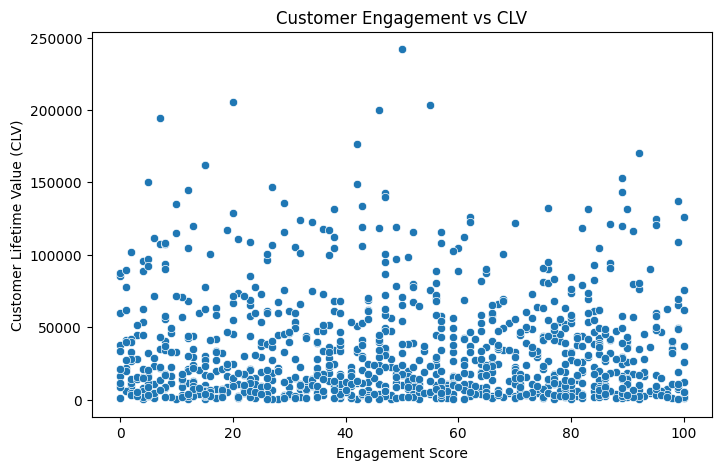


2. Sales Performance Insights:
- Top Performing Category: Dresses
- Average Order Value: $2600.56


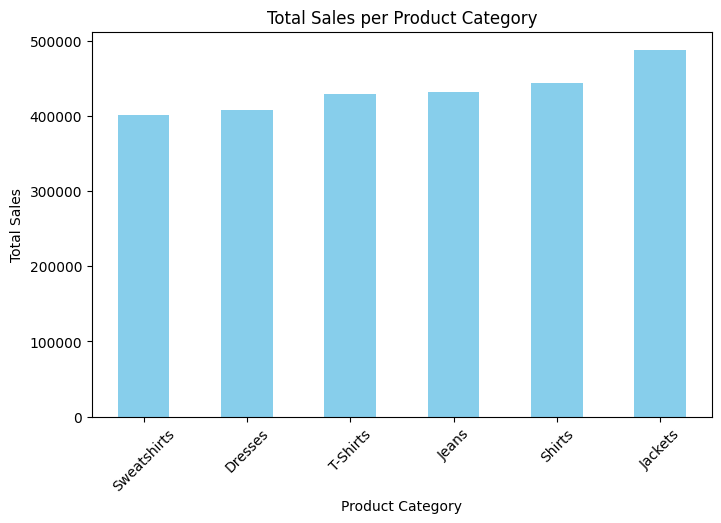


3. Marketing Channel Insights:
- Best Converting Channel: Email Marketing
- Average Engagement Score: 50.44


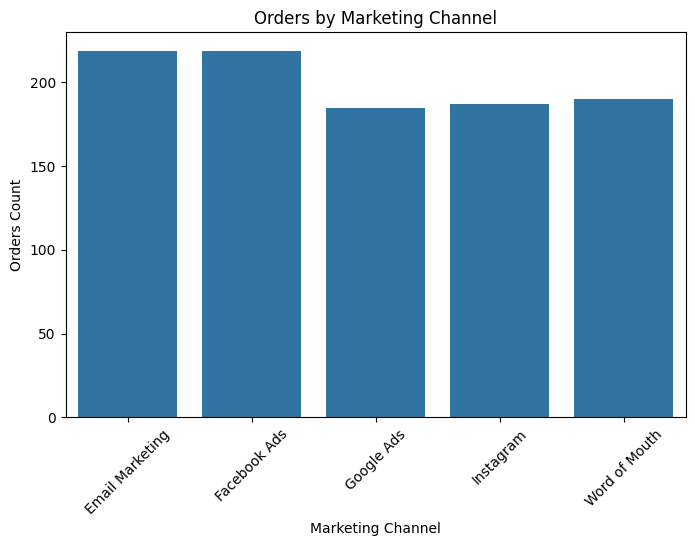


4. Return Analysis Insights:
- Overall Return Rate: 20.4%
- Highest Return Category: Shirts


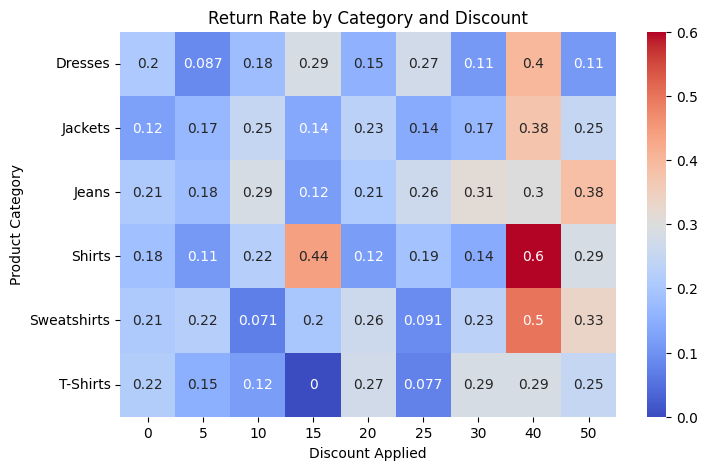


5. Inventory Insights:
- Categories at Risk: Dresses, Jackets, Jeans, T-Shirts


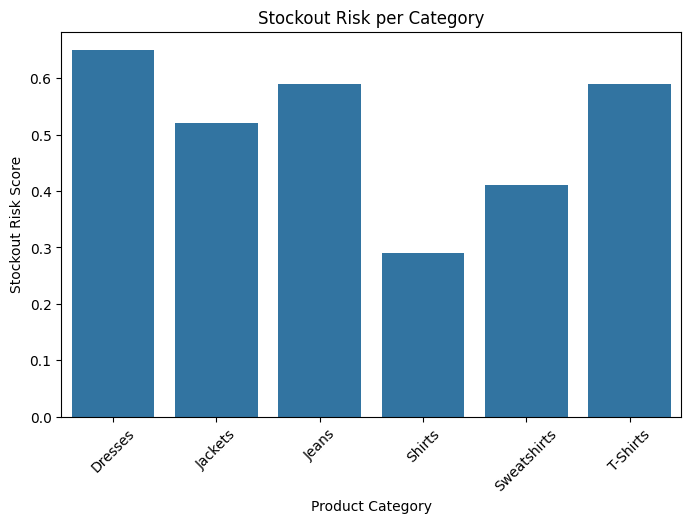


6. Key Recommendations:

Customer Retention:
- Focus on high CLV customers (top 25%)
- Target customers with engagement scores below 26

Marketing Optimization:
- Invest more in Email Marketing which has highest conversion rate
- Improve engagement in Facebook Ads

Inventory Management:
- Monitor Dresses category for stockouts
- Implement predictive reordering for high-risk categories

Return Prevention:
- Review discount strategy for Shirts category
- Optimize product descriptions and sizing guides


In [22]:
if __name__ == "__main__":
    ecommerce_analysis()